# Quantum Energy Teleportation Fully Unitary Protocol 
https://doi.org/10.1103/PhysRevLett.130.110801

### Import packages

In [37]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector, Operator

from qiskit_aer import AerSimulator

## Model

### Functions definitions

In [38]:
def f(h_A,h_B,k):
    return 1/np.sqrt(4*k**2/(h_A+h_B)**2+1)

def Fplus(h_A,h_B,k):
    return np.sqrt(1+f(h_A, h_B, k))

def Fminus(h_A,h_B,k):
    return np.sqrt(1-f(h_A, h_B, k))

def F2plus(h_A,h_B,k):
    return np.sqrt(1+h_B/np.sqrt(h_B**2+4*k**2))

def F2minus(h_A,h_B,k):
    return np.sqrt(1-h_B/np.sqrt(h_B**2+4*k**2))

### Define unitary matrices

In [39]:
def U_rot(h_A, h_B, k):
    U = np.sqrt(1/2) * np.array([ 
        [F2plus(h_A,h_B,k), F2minus(h_A,h_B,k), 0, 0],
        [0, 0, -F2plus(h_A,h_B,k), F2minus(h_A,h_B,k)],
        [0, 0, F2minus(h_A,h_B,k), F2plus(h_A,h_B,k)],
        [-F2minus(h_A,h_B,k), F2plus(h_A,h_B,k), 0, 0]
    ]) 
    return U

def U_diag(h_A, h_B, k): 
    U =  np.sqrt(1/2) * np.array([
        [0, Fplus(h_A,h_B,k), Fminus(h_A,h_B,k), 0],
        [Fminus(h_A,h_B,k), 0, 0, -Fplus(h_A,h_B,k)],
        [Fplus(h_A,h_B,k), 0, 0, Fminus(h_A,h_B,k)],
        [0, -Fminus(h_A,h_B,k), Fplus(h_A,h_B,k), 0]
    ])
    return U

def Y(h_A,h_B,k):
    U = -np.sqrt(1/2) * np.array([
        [Fplus(h_A,h_B,k), Fminus(h_A,h_B,k)],
        [-Fminus(h_A,h_B,k), Fplus(h_A,h_B,k)]
    ]) 
    return U

### Theory

In [40]:
from qiskit.circuit import library
# Parameters
h_A = 1; h_B = 1; k = 1;

# Define basis
ket_0 = np.array([[1],[0]])
ket_1 = np.array([[0],[1]])
ket_00 = np.kron(ket_0,ket_0)
ket_11 = np.kron(ket_1,ket_1)
ket_000 = np.kron(ket_00,ket_0)

# Define base operators
I = Operator.from_label('I').to_matrix(); II = Operator.from_label('II').to_matrix(); III = Operator.from_label('III').to_matrix()
Z_B = Operator.from_label('IIZ').to_matrix(); Z_An = Operator.from_label('IZI').to_matrix(); Z_A = Operator.from_label('ZII').to_matrix()
X_AB = Operator.from_label('XIX').to_matrix(); H_an = Operator.from_label('IHI').to_matrix(); 
cnot = library.CXGate().to_matrix(); swap = library.SwapGate().to_matrix()

# Hamiltonians
H_A = -h_A * Z_A + h_A*f(h_A,h_B,k) * III
H_B = -h_B * Z_B + h_B*f(h_A,h_B,k) * III
V = 2*k * X_AB + 4*k**2/(h_A+h_B)*f(h_A,h_B,k) * III

# Operations
y = np.kron(II,Y(h_A,h_B,k))
CNOT = np.kron(I, cnot)
SWAP = np.kron(swap, I)
U_AnA = np.kron(np.sqrt(1/2)*np.array([[1, 0, 0, 1],[0, 1, 1, 0],[0, -1, 1, 0],[-1, 0, 0, 1]]), I)
U_BAn = np.kron(I,U_rot(h_A,h_B,k)@U_diag(h_A,h_B,k))

# Ground State
ket_G = SWAP@CNOT@y@ket_000
# After measurement State
ket_E = U_AnA @ ket_G
# Final State Density Matrix
P_QET = U_BAn @ (ket_G@ket_G.conj().T) @ U_BAn.conj().T 

# Energies
E_Ha = np.trace(P_QET@H_A).real
E_Hb = np.trace(P_QET@H_B).real
E_V = np.trace(P_QET@V).real
E_A = np.trace(P_QET@(H_A+V)).real
E_B = np.trace(P_QET@(H_B+V)).real 

# Print results
display('Ground State:', Statevector(ket_G).draw('latex'))
display('After Measurement State:', Statevector(ket_E).draw('latex'))
display('Final State Density Matrix:', Operator(P_QET).draw('latex'))

print(f"""
Ground State Energies:
<H_A> = {(ket_G.T@H_A@ket_G)[0][0].real},
<H_B> = {(ket_G.T@H_B@ket_G)[0][0].real},
<V>   = {(ket_G.T@V@ket_G)[0][0].real}.
            
Final Energies:
H_A = {E_Ha},
H_B = {E_Hb},
V = {E_V},
E_A = {E_A},
E_B = {E_B}.
""")

'Ground State:'

<IPython.core.display.Latex object>

'After Measurement State:'

<IPython.core.display.Latex object>

'Final State Density Matrix:'

<IPython.core.display.Latex object>


Ground State Energies:
<H_A> = 0.0,
<H_B> = 0.0,
<V>   = -1.1102230246251565e-16.
            
Final Energies:
H_A = 0.0,
H_B = 1.023334547203386,
V = 2.828427124746192,
E_A = 2.828427124746192,
E_B = 3.8517616719495775.



### Create circuit

In [41]:
def qet(h_A,h_B,k):  

    qc = QuantumCircuit(3,3, metadata={'h':h_A, 'k':k})

    # Prepare ground state
    #theta = -np.arcsin((1/2)**(1/2) * Fminus(h_A,h_B,k))
    #qc.ry(2*theta,0)
 
    qc.unitary(Y(h_A,h_B,k), 0, label='Y')
    qc.cx(0,1)
    qc.swap(1, 2)

    qc.barrier()
    # Auxiliary qubit An gains information of A
    qc.cx(1,2)
    qc.h(1)
    qc.cx(1,2)
    qc.z(1)

    qc.barrier()
    # Energy extraction
    qc.unitary(U_diag(h_A,h_B,k), [1,0], label='U diag')
    qc.unitary(U_rot(h_A,h_B,k), [1,0], label='U rot')

    qc.barrier()
    return qc

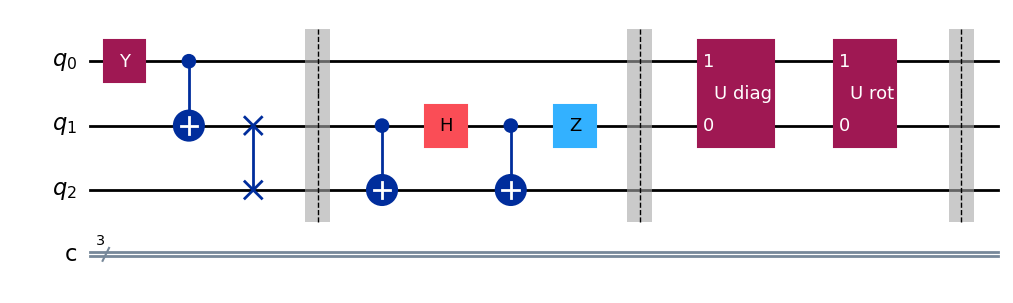

In [42]:
qet(1,1,1).draw('mpl')

## Simulation

### Run simulation

In [43]:
# Initiate simulator
simulator = AerSimulator()

# Parameters
h_A=1;h_B=1;k=1
n_shots = 10000

# Generate circuits
qc_H = qet(h_A,h_B,k)
qc_H.measure_all(add_bits=False)

qc_V = qet(h_A,h_B,k)
qc_V.h(0)
qc_V.h(2)
qc_V.measure_all(add_bits=False)

# Run job
simH = simulator.run(qc_H, shots=n_shots)
simV = simulator.run(qc_V, shots=n_shots)

### Results

H_A = 0.6989067811865474 ± 0.009999663794348287
H_B = 0.2649067811865474 ± 0.008969164732571255


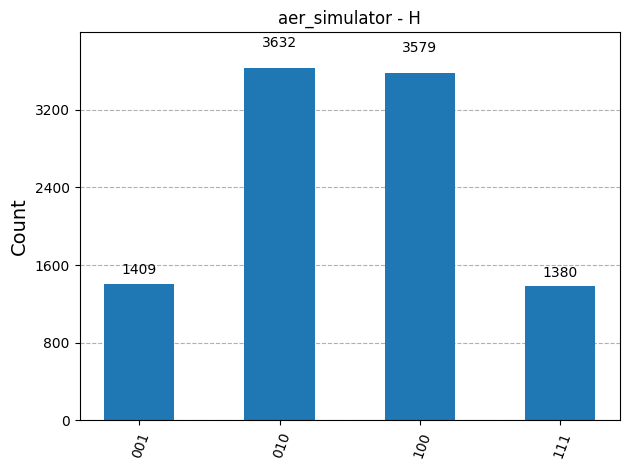

In [44]:
# Extract results
result = simH.result()
counts = result.get_counts()

# Energies
ene_A = f(h_A,h_B,k)*h_A
ene_B = f(h_A,h_B,k)*h_B

# Error arrays
error_A = []
error_B = []

# Sum energy and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]
        ene_A += -h_A*(-1)**int(bit_string[2])*count/n_shots
        ene_B += -h_B*(-1)**int(bit_string[0])*count/n_shots
        for i in range(count):
            error_A.append(-h_A*(-1)**int(bit_string[2]))
            error_B.append(-h_B*(-1)**int(bit_string[0]))

# Show results
print(f"H_A = {ene_A} ± {np.std(error_A)/np.sqrt(n_shots)}")
print(f"H_B = {ene_B} ± {np.std(error_B)/np.sqrt(n_shots)}")
plot_histogram(counts, title="aer_simulator - H")

V = -0.3929864376269051 ± 0.008567544338957341


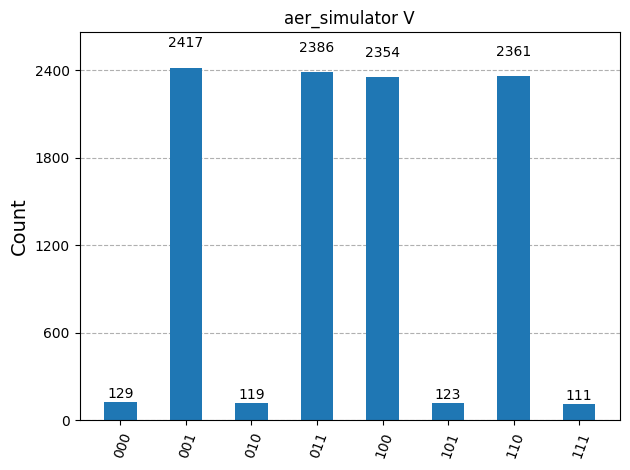

In [45]:
# Extract results
result = simV.result()
counts = result.get_counts()

# Energy
ene_V = f(h_A,h_B,k)*(4*k**2)/(h_A + h_B)

# Error arrays
error_V = []

# Sum energy and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]
        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[2])*count/n_shots
        for i in range(count):
            error_V.append(2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[2]))

# Show results
print(f"V = {ene_V} ± {np.std(error_V)/np.sqrt(n_shots)}")
plot_histogram(counts, title='aer_simulator V')

## Run circuit on hardware

### Import IBM packages

In [ ]:
from qiskit_ibm_runtime import (QiskitRuntimeService, 
                                Batch, 
                                SamplerV2 as sampler, 
                                EstimatorV2 as estimator)
from qiskit.transpiler import preset_passmanagers
from qiskit.quantum_info import SparsePauliOp 

### Get backend

In [ ]:
# Log in IBM platform
service = QiskitRuntimeService()

# Select least busy backend
backend = service.least_busy()
print(backend.name)

### Run job with sampler

In [ ]:
# Parameters h and k
variables = [(1,1.5), (1,1), (1,0.5), (0.5, 1), (1.5, 1)]
n_shots = 3000

#  Run job in Batch mode
with Batch(backend=backend):
    
    # initiate sampler and configure error mitigation
    sampler = sampler()
    options = sampler.options
    options.dynamical_decoupling.enable = True
    options.twirling.enable_gates = True
    options.twirling.enable_measure= True

    for variable in variables:
        h_A = variable[0]
        h_B = h_A
        k = variable[1]

        # Generate circuits
        circuit_H = qet(h_A,h_B,k)
        circuit_H.measure_all(add_bits=False)
        transpiled_H = transpile(circuit_H, backend=backend, optimization_level=3)

        circuit_V = qet(h_A,h_B,k)
        circuit_V.barrier()
        circuit_V.h(0)
        circuit_V.h(2)
        circuit_V.measure_all(add_bits=False)
        transpiled_V = transpile(circuit_V, backend=backend, optimization_level=3)
        
        # Run job
        job_A = sampler.run([(transpiled_H), (transpiled_V)], shots=n_shots)
        job_A.update_tags([f'k={k},h={h_A}','error mitigated','sampler','FU',f'{n_shots}'])  # Add tags to job
        print(f"Sampler, ID = {job_A.job_id()}, h = {h_A} k = {k}")

base_primitive._get_mode_service_backend:WARNING:2025-10-31 18:06:14,046: A backend was passed in as the mode but a session context manager is open so this job will run inside this session/batch instead of in job mode.


Sampler, ID = d42j5p87i53s73e37lo0, h = 1 k = 1.5
Sampler, ID = d42j5t07i53s73e37ls0, h = 1 k = 1
Sampler, ID = d42j60lo35ts73c6s5n0, h = 1 k = 0.5
Sampler, ID = d42j63to35ts73c6s5qg, h = 0.5 k = 1
Sampler, ID = d42j6710f7bc7387hkhg, h = 1.5 k = 1


### Run job with estimator

In [ ]:
# Parameters h and k
variables = [(1,1.5), (1,1), (1,0.5), (0.5, 1), (1.5, 1)]

# Configure the transpiler
transpiler = preset_passmanagers.generate_preset_pass_manager(optimization_level=3, backend=backend)

#  Run job in Batch mode
with Batch(backend=backend):

    for variable in variables:
        h_A = variable[0]
        h_B = h_A
        k = variable[1]
        observables = [SparsePauliOp('IIZ', -h_B), SparsePauliOp('XIX', 2*k)]

        # Generate circuit
        circuit_T = qet(h_A,h_B,k)
        transpiled_T = transpiler.run(circuit_T)
        
        # Run job
        transpiled_observables = [observable.apply_layout(transpiled_T.layout) for observable in observables]
        job_B = estimator(options={'resilience_level':2}).run([(transpiled_T, transpiled_observables)]) # transpiled_observables[0] or [1] to run separately
        job_B.update_tags([f'k={k},h={h_A}','error mitigated','estimator','FU']) # Add tags
        print(f"Estimator, ID = {job_B.job_id()}, h = {h_A} k = {k}") 

Estimator, ID = d42j691ag40c7383vp40, h = 1 k = 1.5
Estimator, ID = d42j69pag40c7383vp50, h = 1 k = 1
Estimator, ID = d42j6ahag40c7383vp5g, h = 1 k = 0.5
Estimator, ID = d42j6bdo35ts73c6s61g, h = 0.5 k = 1
Estimator, ID = d42j6bp0f7bc7387hkmg, h = 1.5 k = 1


### Results

### Show results for circuit H

In [ ]:
# Extract results

# Sampler
jobS = service.job('') 
result = jobS.result()[0]
counts = result.data.meas.get_counts()
n_shots = result.data.meas.num_shots

# Estimator
jobT = service.job('')
result = jobT.result()[0]
exp_value = result.data.evs[0]
value_error = result.data.stds[0]

# Parameters
metadata = result.metadata.get('circuit_metadata')
k = metadata.get('k')
h_A = metadata.get('h')
h_B = h_A

# Energies
ene_B = f(h_A,h_B,k)*h_B
est_B = exp_value + ene_B

# Error array
error_B = []

# Sum energy and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]  # Invert bits ordering 
        ene_B += -h_B*(-1)**int(bit_string[0])*count/n_shots
        for i in range(count):
            error_B.append(-h_B*(-1)**int(bit_string[0]))

# Show results
print(f"  Sampler H_B = {ene_B} ± {np.std(error_B)/np.sqrt(n_shots)}")
print(f"Estimator H_B = {est_B} ± {value_error}")
plot_histogram(counts, title=f"{jobS.backend().name} - H")

### Show results for circuit H

In [ ]:
# Extract results

# Sampler
jobS = service.job('')
result = jobS.result()[1]
counts = result.data.meas.get_counts()
n_shots = result.data.meas.num_shots

# Estimator
jobT = service.job('')
result = jobT.result()[0]
exp_value = result.data.evs[2]
value_error = result.data.stds[2]

# Parameters
metadata = result.metadata.get('circuit_metadata')
k = metadata.get('k')
h_A = metadata.get('h')
h_B = h_A 

# Energies
ene_V = f(h_A,h_B,k)*(4*k**2)/(h_A + h_B)
est_V = exp_value + ene_V

# Error array
error_V = []

# Sum energy and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]  # Invert bits ordering 
        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[2])*count/n_shots
        for i in range(count):
            error_V.append(2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[2]))

# Show results
print(f"  Sampler V = {ene_V} ± {np.std(error_V)/np.sqrt(n_shots)}")
print(f"Estimator V = {est_V} ± {value_error}")
plot_histogram(counts, title=f"{jobS.backend().name} - V")